In [1]:
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

noise = 16
seed = 244823
samples = 2423
loop = 5
plt.rcParams['figure.figsize'] = [8, 8]

class DecisionClassifier():
    class Node():
        def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
            self.feature_index = feature_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.info_gain = info_gain
            self.value = value

    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None

        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):

        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)

        if num_samples>=self.min_samples_split and curr_depth<self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if len(best_split) != 0:
                if best_split["info_gain"]>0:
                    left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                    right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                    return self.Node(best_split["feature_index"], best_split["threshold"],
                                left_subtree, right_subtree, best_split["info_gain"])

        leaf_value = self.calculate_leaf_value(Y)
        return self.Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):

        best_split = {}
        max_info_gain = -float('inf')

        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left = dataset[dataset[:, feature_index] <= threshold]
                dataset_right = dataset[dataset[:, feature_index] > threshold]
                if len(dataset_left)>0 and len(dataset_right)>0:
                    curr_info_gain = self.information_gain(dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1])
                    if curr_info_gain>max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain

        return best_split

    def split(self, dataset, feature_index, threshold):
        X_left = []
        X_right = []
        for i, row in enumerate(dataset):
            if row[feature_index] <= threshold:
                X_left.append(row)
            else:
                X_right.append(row)

        return np.array(X_left), np.array(X_right)

    def information_gain(self, parent, l_child, r_child):

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        gain = self.gini(parent) - (weight_l*self.gini(l_child) + weight_r*self.gini(r_child))
        return gain

    def gini(self, y):
        ''' function to compute gini index '''

        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini

    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)

    def print_tree(self, tree=None, indent=" "):

        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("Feature "+str(tree.feature_index), "=", tree.threshold, ", information gain:", tree.info_gain)
            print("%sleft: " % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright: " % (indent), end="")
            self.print_tree(tree.right, indent + indent)

    def fit(self, X, Y):
        dataset = np.column_stack((X, Y))
        self.root = self.build_tree(dataset)

    def predict(self, X):
        pred = np.empty(shape=len(X))
        for i in range(len(X)):
            pred[i] = self.make_prediction(X[i], self.root)
        return pred

    def make_prediction(self, x, tree):
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

class RandomForest:
    def __init__(self, n_estimators, min_samples_split, max_depth):
        self.n_estimators = n_estimators
        self.min_sample_split = min_samples_split
        self.max_depth = max_depth
        self.estimators = []
        pass

    def fit(self, X, y):
        self.estimators = [DecisionClassifier(self.min_sample_split, self.max_depth) for _ in range(self.n_estimators)]
        for e in self.estimators:
            sample_idx = np.random.choice(X.shape[0], X.shape[0])
            e.fit(X[sample_idx], y[sample_idx])
        pass


    def predict(self, X):
        all = []
        for e in self.estimators:
            all.append([int(xxx) for xxx in e.predict(X)])
        all = np.array(all).T

        return np.array([np.argmax(np.bincount(pred)) for pred in all])

def cm(ytest, ypred, title, showplot=True):
    cm = confusion_matrix(ytest, ypred)
    tn, fp, fn, tp = confusion_matrix(ytest, ypred).ravel()

    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    balacc = (sensitivity+specificity)/2
    f1score = 2*(sensitivity*specificity)/(specificity+sensitivity)

    if showplot:
        cm = ConfusionMatrixDisplay(confusion_matrix=cm)
        cm.plot(cmap='binary')
        plt.title(title)
        plt.show()
    return sensitivity, specificity, balacc, f1score

def kontur(xtrain, ytrain, title):

    x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
    y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = np.asarray(classifier.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.title(title)
    plt.contourf(xx, yy, Z, alpha=0.6)
    plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, alpha=0.4)
    plt.show()

def sklkontur(xtrain, ytrain, title):

    x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
    y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    Z = np.asarray(tree_model.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.title(title)
    plt.contourf(xx, yy, Z, alpha=0.6)
    plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, alpha=0.4)
    plt.show()


<h3 align="center"><font size="10">Część 1</font></h3>

In [2]:
x, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=seed, shuffle=True, stratify=y)
ytrain = ytrain.reshape(-1,1)
ytest = ytest.reshape(-1,1)

<h3 align="center"><font size="10">1 klaster na klasę / max depth = liczba próbek</font></h3>

<h3 align="center"><font size="10">Model własny</font></h3>

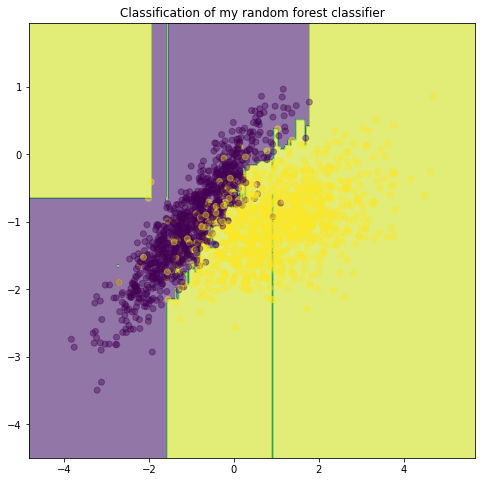

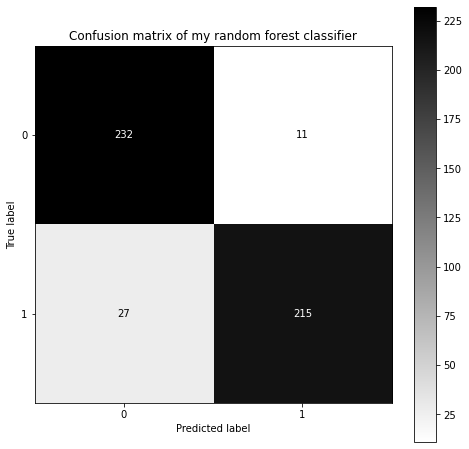

In [3]:
classifier = RandomForest(n_estimators=10, min_samples_split=2, max_depth=1938)
classifier.fit(xtrain, ytrain)
ypred = classifier.predict(xtest)
kontur(xtrain, ytrain, 'Classification of my random forest classifier')
own_sensitivity_max_1cl, own_specificity_max_1cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of my random forest classifier')

In [4]:
start = time.time()
for i in range(loop):
    classifier.fit(xtrain,ytrain)
    ypred = classifier.predict(xtest)
own_endtime_features = (time.time() - start)/loop
print(own_endtime_features)

22.51478519439697


<h3 align="center"><font size="10">Model sklearn</font></h3>

In [5]:
tree_model = RandomForestClassifier(n_estimators=10, min_samples_split=2, max_depth=1938, criterion='gini')
tree_model = tree_model.fit(xtrain, ytrain.ravel())

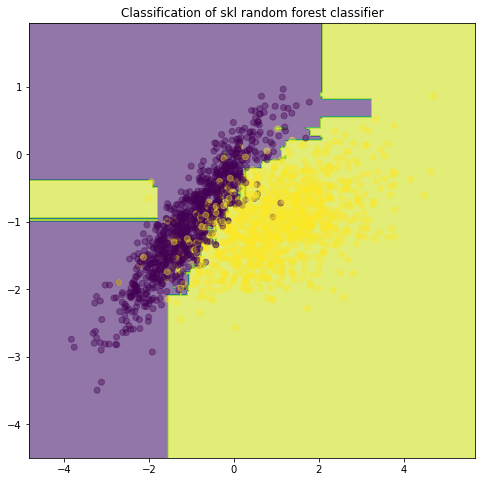

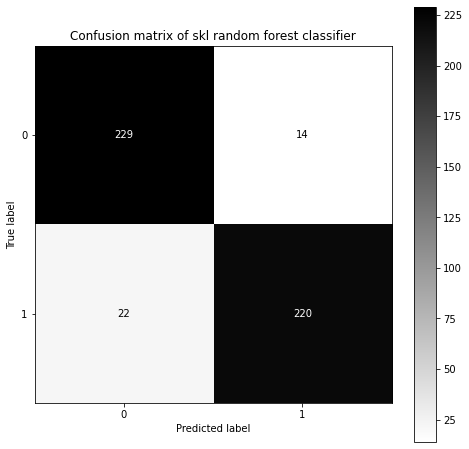

In [6]:
ypred = tree_model.predict(xtest)
plt.rcParams['figure.figsize'] = [8, 8]
sklkontur(xtrain, ytrain, 'Classification of skl random forest classifier')
skl_sensitivity_max_1cl, skl_specificity_max_1cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of skl random forest classifier')

In [7]:
start = time.time()
for i in range(loop):
    tree_model = tree_model.fit(xtrain, ytrain.ravel())
    ypred = tree_model.predict(xtest)
skl_endtime_features = (time.time() - start)/loop
print(skl_endtime_features)

0.028969478607177735


<h3 align="center"><font size="10">2 klastry na klasę / max depth = liczba próbek</font></h3>

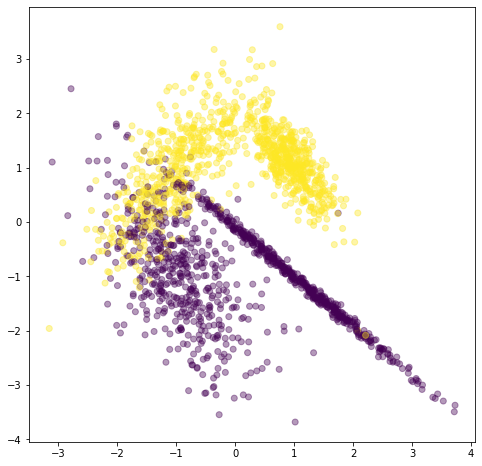

In [8]:
x, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=2, n_informative=2)
xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=seed, shuffle=True, stratify=y)
ytrain = ytrain.reshape(-1,1)
ytest = ytest.reshape(-1,1)
plt.scatter(xtrain[:, 0], xtrain[:, 1], c=ytrain, alpha=0.4)
plt.show()

<h3 align="center"><font size="10">Model własny</font></h3>

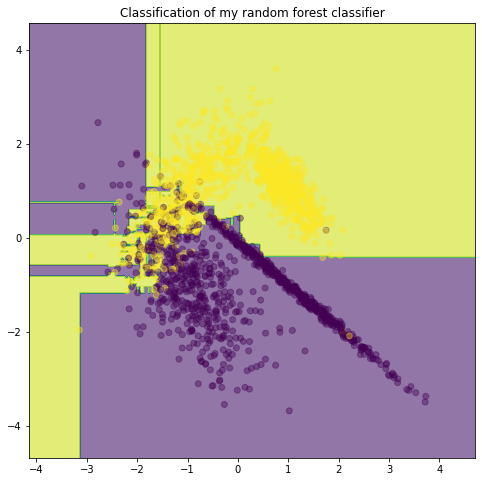

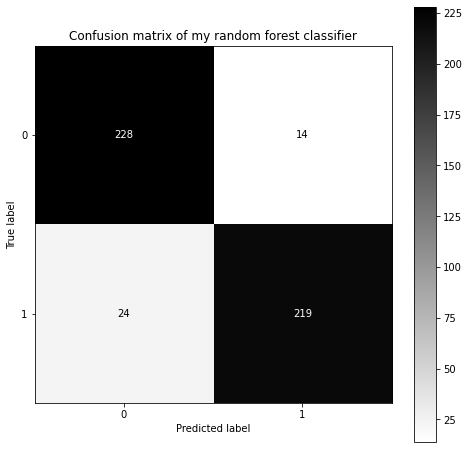

In [9]:
classifier = RandomForest(n_estimators=10, min_samples_split=2, max_depth=1938)
classifier.fit(xtrain, ytrain)
ypred = classifier.predict(xtest)
kontur(xtrain, ytrain, 'Classification of my random forest classifier')
own_sensitivity_max_2cl, own_specificity_max_2cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of my random forest classifier')

<h3 align="center"><font size="10">Model sklearn</font></h3>

In [10]:
tree_model = RandomForestClassifier(n_estimators=10, min_samples_split=2, max_depth=1938, criterion='gini')
tree_model = tree_model.fit(xtrain, ytrain.ravel())

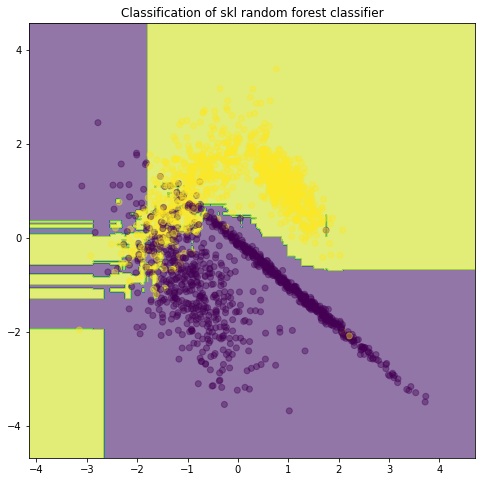

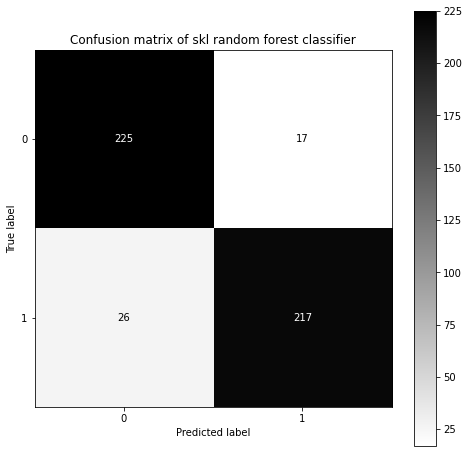

In [11]:
ypred = tree_model.predict(xtest)
plt.rcParams['figure.figsize'] = [8, 8]
sklkontur(xtrain, ytrain, 'Classification of skl random forest classifier')
skl_sensitivity_max_2cl, skl_specificity_max_2cl, balacc, f1score = cm(ytest, ypred, 'Confusion matrix of skl random forest classifier')

In [12]:
print(f'The runtime of my own model is {own_endtime_features} \n'
      f'The runtime of skl model is {skl_endtime_features} \n'

      f'The specificity of my own model with 1 cluster per class and max depth = samples is {round(own_specificity_max_1cl, 4)} \n'
      f'The sensitivity of my own model with 1 cluster per class and max depth = samples is {round(own_sensitivity_max_1cl, 4)} \n'
      f'The specificity of skl model with 1 cluster per class and max depth = samples is {round(skl_specificity_max_1cl, 4)} \n'
      f'The sensitivity of skl model with 1 cluster per class and max depth = samples is {round(skl_sensitivity_max_1cl, 4)} \n\n'

      f'The specificity of my own model with 2 cluster per class and max depth = samples is {round(own_specificity_max_1cl, 4)} \n'
      f'The sensitivity of my own model with 2 cluster per class and max depth = samples is {round(own_sensitivity_max_1cl, 4)} \n'
      f'The specificity of skl model with 2 cluster per class and max depth = samples is {round(skl_specificity_max_1cl, 4)} \n'
      f'The sensitivity of skl model with 2 cluster per class and max depth = samples is {round(skl_sensitivity_max_1cl, 4)} \n\n')

The runtime of my own model is 22.51478519439697 
The runtime of skl model is 0.028969478607177735 
The specificity of my own model with 1 cluster per class and max depth = samples is 0.9547 
The sensitivity of my own model with 1 cluster per class and max depth = samples is 0.8884 
The specificity of skl model with 1 cluster per class and max depth = samples is 0.9424 
The sensitivity of skl model with 1 cluster per class and max depth = samples is 0.9091 

The specificity of my own model with 2 cluster per class and max depth = samples is 0.9547 
The sensitivity of my own model with 2 cluster per class and max depth = samples is 0.8884 
The specificity of skl model with 2 cluster per class and max depth = samples is 0.9424 
The sensitivity of skl model with 2 cluster per class and max depth = samples is 0.9091 




<h3 align="center"><font size="10">Część 2</font></h3>

<h3 align="center"><font size="10">Label neo</font></h3>

In [2]:
cosmos = pd.read_csv('dataset.csv', delimiter=',')
cosmos

C:\Users\Jakub Kowalczewski\AppData\Local\Temp\ipykernel_12952\760099783.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmos = pd.read_csv('dataset.csv', delimiter=',')


,id,spkid,full_name,pdes,name,prefix,neo,pha,H,diameter,...,sigma_i,sigma_om,sigma_w,sigma_ma,sigma_ad,sigma_n,sigma_tp,sigma_per,class,rms
0,a0000001,2000001,1 Ceres,1,Ceres,NaN,N,N,3.400,939.400,...,4.608900e-09,6.168800e-08,6.624800e-08,7.820700e-09,1.111300e-11,1.196500e-12,3.782900e-08,9.415900e-09,MBA,0.43301
1,a0000002,2000002,2 Pallas,2,Pallas,NaN,N,N,4.200,545.000,...,3.469400e-06,6.272400e-06,9.128200e-06,8.859100e-06,4.961300e-09,4.653600e-10,4.078700e-05,3.680700e-06,MBA,0.35936
2,a0000003,2000003,3 Juno,3,Juno,NaN,N,N,5.330,246.596,...,3.223100e-06,1.664600e-05,1.772100e-05,8.110400e-06,4.363900e-09,4.413400e-10,3.528800e-05,3.107200e-06,MBA,0.33848
3,a0000004,2000004,4 Vesta,4,Vesta,NaN,N,N,3.000,525.400,...,2.170600e-07,3.880800e-07,1.789300e-07,1.206800e-06,1.648600e-09,2.612500e-10,4.103700e-06,1.274900e-06,MBA,0.39980
4,a0000005,2000005,5 Astraea,5,Astraea,NaN,N,N,6.900,106.699,...,2.740800e-06,2.894900e-05,2.984200e-05,8.303800e-06,4.729000e-09,5.522700e-10,3.474300e-05,3.490500e-06,MBA,0.52191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958519,bPLS6013,3246801,(6013 P-L),6013 P-L,NaN,NaN,N,N,17.135,NaN,...,6.969000e+00,7.433000e+00,4.631100e+01,2.738300e+01,1.041200e+00,1.652100e-01,1.309700e+02,7.264900e+02,MBA,0.23839
958520,bPLS6331,3246834,(6331 P-L),6331 P-L,NaN,NaN,N,N,18.500,NaN,...,1.563500e-05,5.598600e-05,2.380400e-04,1.298200e-04,2.418900e-08,3.346100e-09,4.690200e-04,1.578500e-05,MBA,0.53633
958521,bPLS6344,3013075,(6344 P-L),6344 P-L,NaN,NaN,Y,Y,20.400,NaN,...,1.853300e-05,5.691700e-05,8.969200e-05,5.272600e-05,1.650100e-07,1.101600e-08,2.830600e-04,9.127500e-05,APO,0.51556
958522,bT2S2060,3246457,(2060 T-2),2060 T-2,NaN,NaN,N,N,18.071,NaN,...,5.448800e-01,4.391600e+00,1.898800e+01,1.083800e+01,7.171600e-01,1.016700e-01,3.898400e+01,5.035500e+02,MBA,0.25641


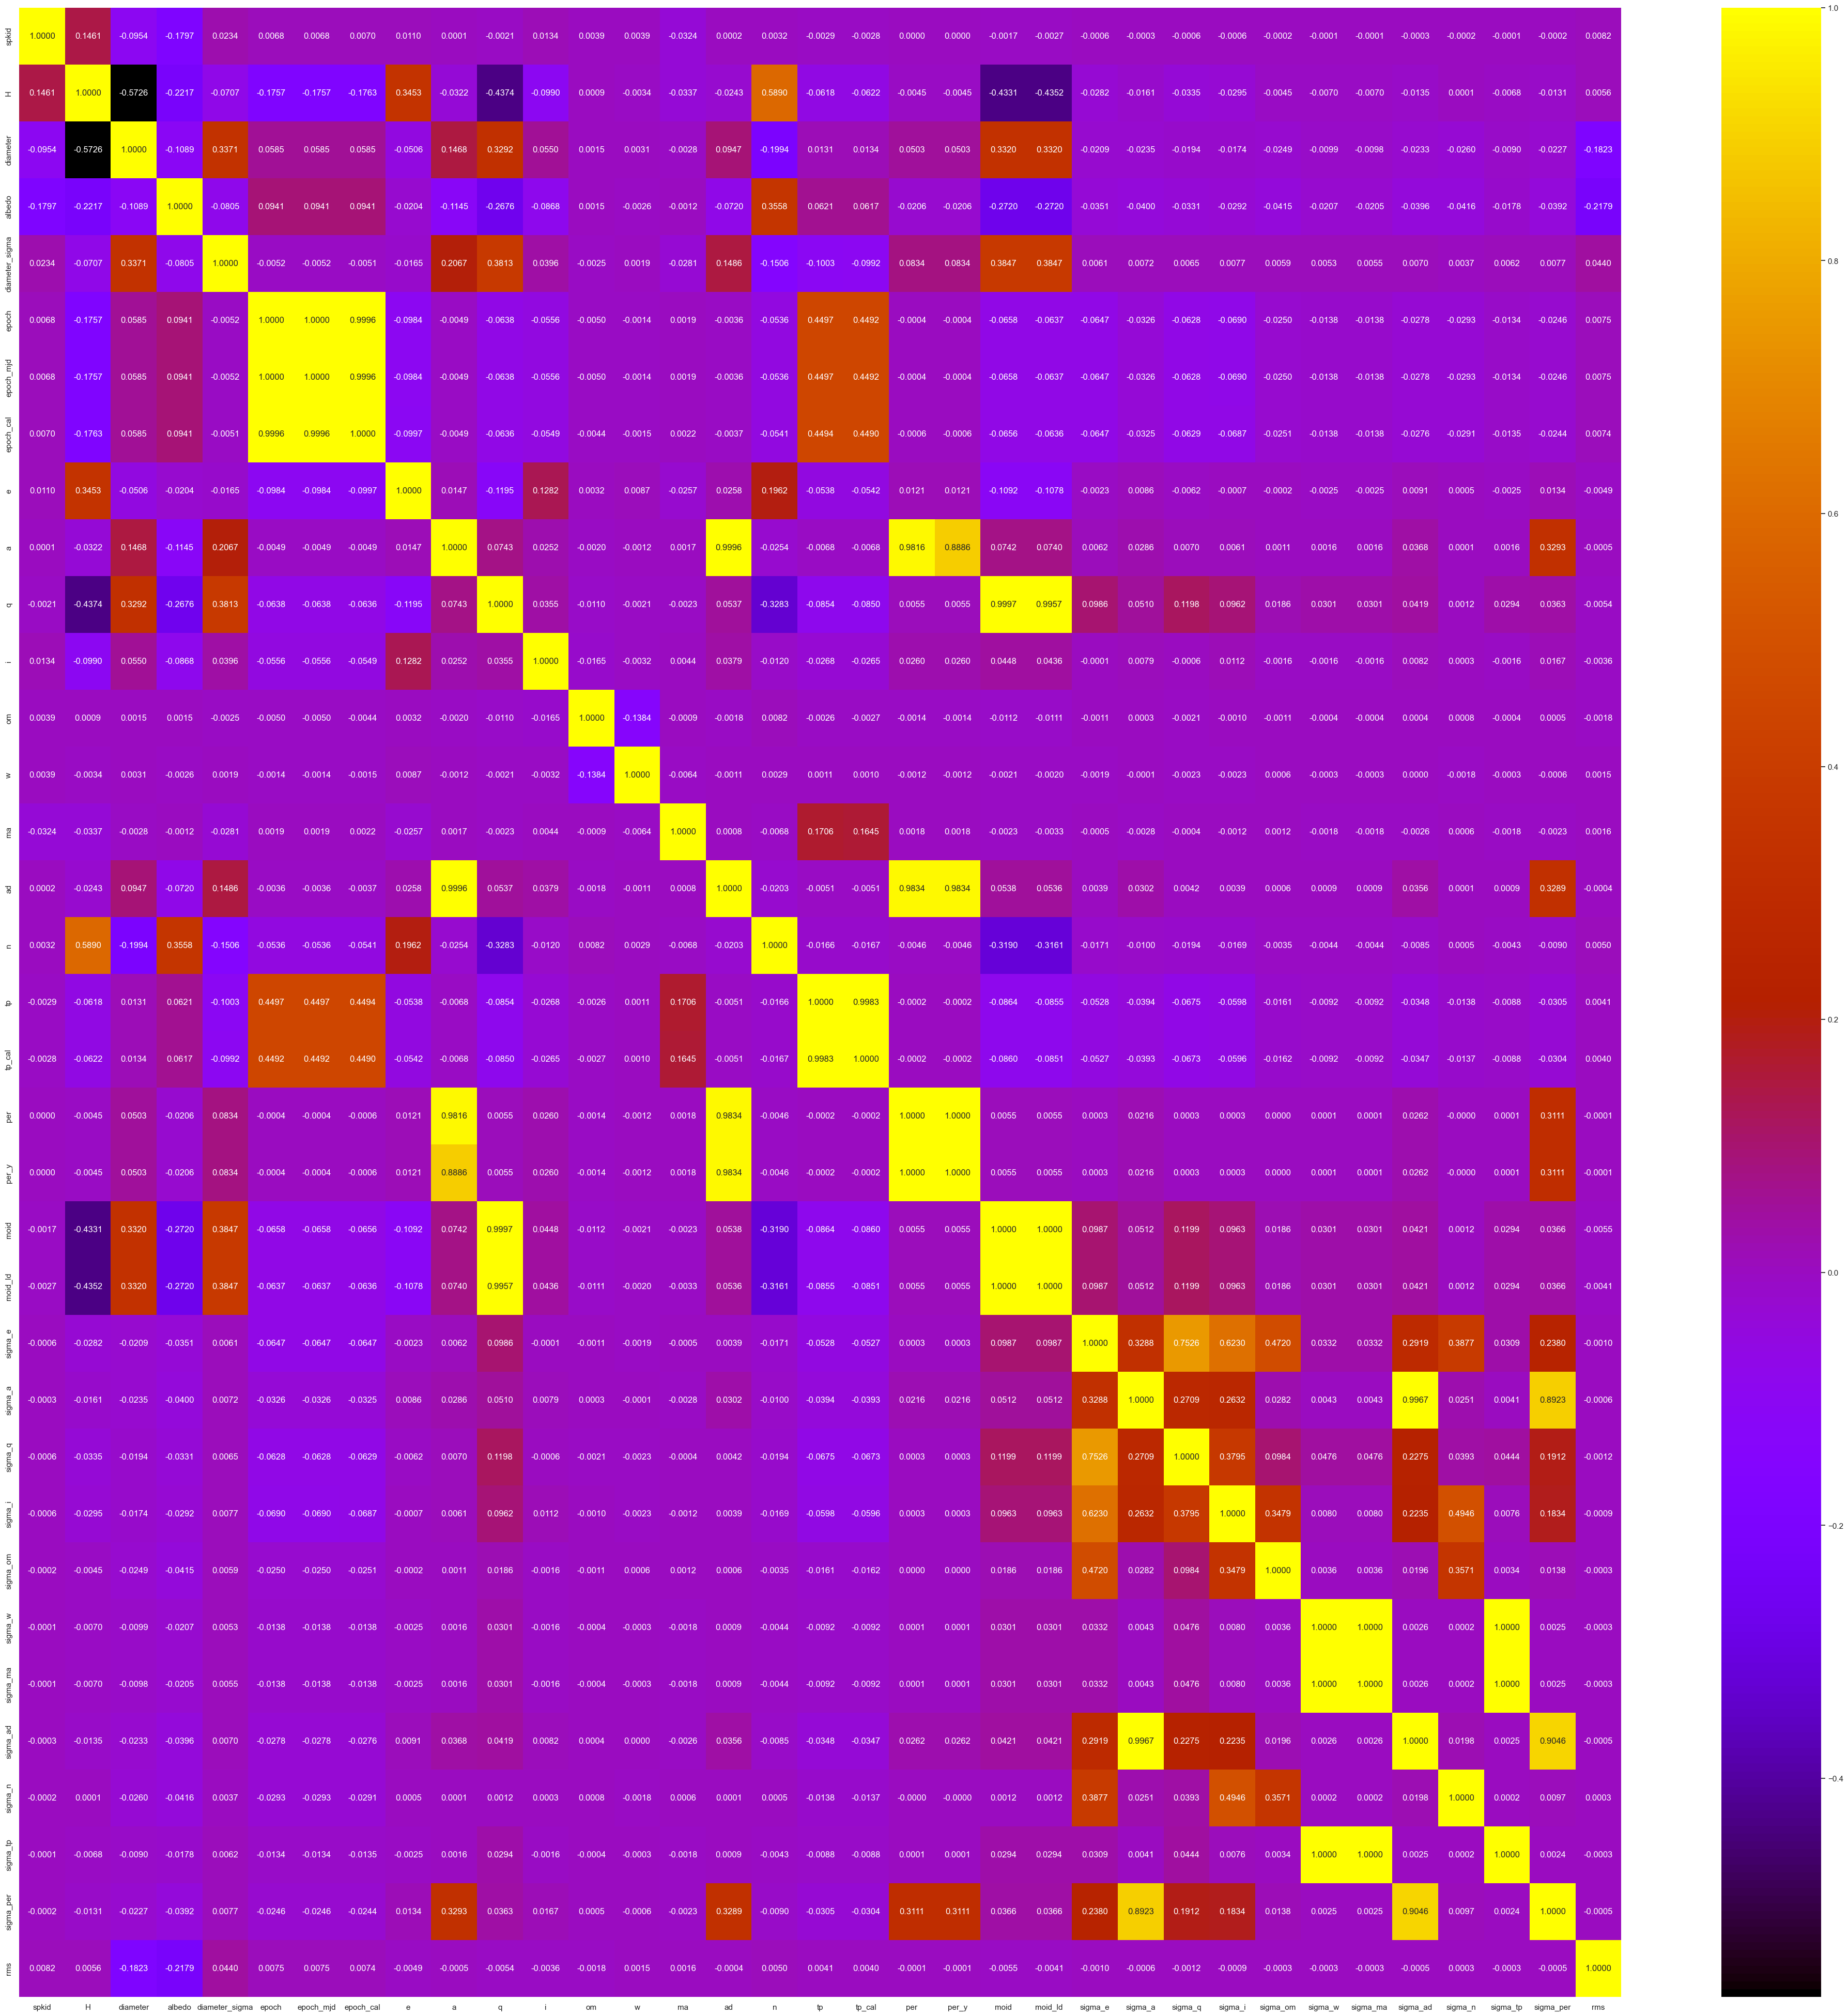

In [41]:
heatmap = cosmos.corr()
sns.set(rc = {'figure.figsize':(50,50)})
sns.heatmap(heatmap, annot = True, fmt='.4f', cmap='gnuplot')
plt.show()

In [3]:
sns.reset_defaults()
cosmos = cosmos.drop(columns=['pha', 'epoch', 'equinox', 'orbit_id', 'id', 'spkid', 'full_name', 'pdes', 'epoch_cal', 'epoch_mjd', 'ad', 'per', 'per_y', 'moid', 'moid_ld', 'sigma_ad', 'sigma_per', 'sigma_ma', 'sigma_tp', 'tp_cal', 'sigma_q', 'sigma_i', 'rms'])
cosmos = cosmos.dropna(axis=1, thresh=(958524-958524*0.3))
cosmos = cosmos.dropna(axis=0, subset='neo')
cosmos.reset_index(inplace=True, drop=True)
y = cosmos[['neo']]
cosmos = cosmos.drop(columns=['neo'])

In [43]:
cosmos

,H,e,a,q,i,om,w,ma,n,tp,sigma_e,sigma_a,sigma_om,sigma_w,sigma_n,class
0,3.400,0.076009,2.769165,2.558684,10.594067,80.305531,73.597695,77.372098,0.213885,2.458239e+06,4.819000e-12,1.032800e-11,6.168800e-08,6.624800e-08,1.196500e-12,MBA
1,4.200,0.229972,2.773841,2.135935,34.832932,173.024741,310.202392,144.975675,0.213345,2.458321e+06,3.193400e-08,4.033700e-09,6.272400e-06,9.128200e-06,4.653600e-10,MBA
2,5.330,0.256936,2.668285,1.982706,12.991043,169.851482,248.066193,125.435355,0.226129,2.458446e+06,3.052000e-08,3.471800e-09,1.664600e-05,1.772100e-05,4.413400e-10,MBA
3,3.000,0.088721,2.361418,2.151909,7.141771,103.810804,150.728541,95.861938,0.271609,2.458248e+06,2.332100e-10,1.514300e-09,3.880800e-07,1.789300e-07,2.612500e-10,MBA
4,6.900,0.190913,2.574037,2.082619,5.367427,141.571026,358.648418,17.846343,0.238661,2.458926e+06,2.373700e-08,3.970900e-09,2.894900e-05,2.984200e-05,5.522700e-10,MBA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958515,17.135,0.185919,2.280861,1.856807,5.984416,194.229902,195.442802,342.057565,0.286125,2.437266e+06,2.142200e-02,8.779900e-01,7.433000e+00,4.631100e+01,1.652100e-01,MBA
958516,18.500,0.282920,2.334910,1.674319,8.082280,355.248239,5.216223,260.113042,0.276248,2.459362e+06,2.642000e-07,1.885500e-08,5.598600e-05,2.380400e-04,3.346100e-09,MBA
958517,20.400,0.662446,2.817152,0.950941,4.679278,182.982832,234.894852,240.473601,0.208444,2.459574e+06,6.636800e-08,9.925600e-08,5.691700e-05,8.969200e-05,1.101600e-08,APO
958518,18.071,0.202053,2.373137,1.893638,0.732484,176.499082,198.026527,355.351127,0.269600,2.441974e+06,3.169800e-02,5.966200e-01,4.391600e+00,1.898800e+01,1.016700e-01,MBA


In [44]:
cosmos.isna().sum()
# print(cosmos.nunique())

H            6263
e               0
a               0
q               0
i               0
om              0
w               0
ma              1
n               0
tp              0
sigma_e     19922
sigma_a     19922
sigma_om    19922
sigma_w     19922
sigma_n     19922
class           0
dtype: int64

In [4]:
cosmos.fillna(
    {
        'class': cosmos['class'].mode().values[0],
        'H': cosmos['H'].median(),
        'ma': cosmos['ma'].mean(),
        'sigma_e': cosmos['sigma_e'].mean(),
        'sigma_a': cosmos['sigma_a'].mean(),
        'sigma_om': cosmos['sigma_om'].mean(),
        'sigma_w': cosmos['sigma_w'].mean(),
        'sigma_n': cosmos['sigma_n'].mean(),
    },
    inplace=True
)
# cosmos.isna().sum()

In [46]:
# for i in cosmos.columns:
#         if cosmos[i].dtype == 'float64':
#             print(cosmos[i].mean())
# y['neo'].unique()

In [5]:
def windsorize(dataframe):
    for i in dataframe.columns:
        if dataframe[i].dtype == 'float64':
            q3, q1 = np.percentile(dataframe[i], [75, 25])
            iqr = q3 - q1
            lowerbound = q1 - 1.5*iqr
            upperbound = q3 + 1.5*iqr
            dataframe.loc[dataframe[i] < lowerbound, i] = lowerbound
            dataframe.loc[dataframe[i] > upperbound, i] = upperbound

def normalize2(dataframe):
    return (dataframe-dataframe.min())/(dataframe.max()-dataframe.min())

windsorize(cosmos)

In [6]:
from sklearn import preprocessing
onehot = preprocessing.OneHotEncoder(sparse=False)
le = preprocessing.LabelEncoder()
xtrain, xtest, ytrain, ytest= train_test_split(cosmos, y, stratify=y, test_size=0.001, train_size=0.002, random_state=seed)

def preprocess(x,y):
    x.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    label_name = y.columns

    y = y.to_numpy()
    y = pd.DataFrame(le.fit_transform(y.ravel()))
    y.rename(columns={0: str(label_name[0])}, inplace=True)

    columnscat = ['class']
    columnfloat = cosmos.drop(columns=columnscat).columns

    scaled = normalize2(x[columnfloat])
    encoding = pd.DataFrame(onehot.fit_transform(x[columnscat]))

    encoding.columns = onehot.get_feature_names_out()

    cosmos_processed = pd.concat([scaled, encoding], axis=1)
    return cosmos_processed, y

xtrain_processed, ytrain_processed = preprocess(xtrain,ytrain)
xtest_processed, ytest_processed = preprocess(xtest, ytest)

In [49]:
params = [{'n_estimators': [5, 10, 100, 500],
           'max_depth': [5, 10, 100],
           'criterion': ['gini', 'entropy'],
           'min_samples_split': [2, 10, 100],
           'min_samples_leaf': [2, 10, 100]}]
tree_model = RandomForestClassifier()
ytrain_processed.squeeze().ravel()
model = GridSearchCV(tree_model, param_grid=params, scoring='accuracy', cv=5)
model.fit(xtrain_processed, ytrain_processed.squeeze().ravel())
model.best_params_

{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 100}

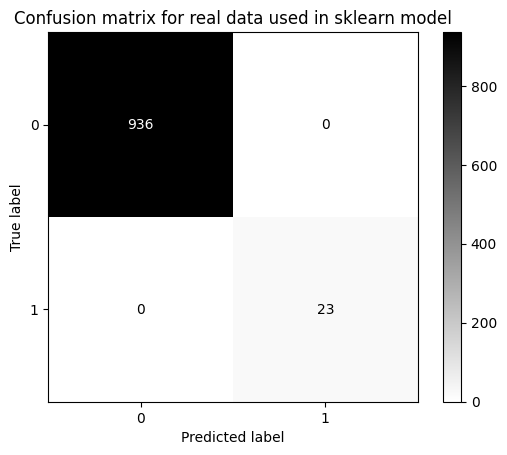

In [8]:
tree_model = RandomForestClassifier(criterion='gini', max_depth=10, min_samples_split=2, min_samples_leaf=2, n_estimators=100)
tree_model.fit(xtrain_processed,ytrain_processed.squeeze().ravel())
ypred = tree_model.predict(xtest_processed)
sensitivity, specificity, c, d = cm(ytest_processed, ypred, 'Confusion matrix for real data used in sklearn model')

<h3 align="center"><font size="10">Label pha</font></h3>

In [9]:
cosmos = pd.read_csv('dataset.csv', delimiter=',')
cosmos = cosmos.drop(columns=['neo', 'epoch', 'equinox', 'orbit_id', 'id', 'spkid', 'full_name', 'pdes', 'epoch_cal', 'epoch_mjd', 'ad', 'per', 'per_y', 'moid', 'moid_ld', 'sigma_ad', 'sigma_per', 'sigma_ma', 'sigma_tp', 'tp_cal', 'sigma_q', 'sigma_i', 'rms'])
cosmos = cosmos.dropna(axis=1, thresh=(958524-958524*0.3))
cosmos = cosmos.dropna(axis=0, subset='pha')
cosmos.reset_index(inplace=True, drop=True)
y = cosmos[['pha']]
cosmos = cosmos.drop(columns=['pha'])
cosmos.fillna(
    {
        'class': cosmos['class'].mode().values[0],
        'H': cosmos['H'].median(),
        'ma': cosmos['ma'].mean(),
        'sigma_e': cosmos['sigma_e'].mean(),
        'sigma_a': cosmos['sigma_a'].mean(),
        'sigma_om': cosmos['sigma_om'].mean(),
        'sigma_w': cosmos['sigma_w'].mean(),
        'sigma_n': cosmos['sigma_n'].mean(),
    },
    inplace=True
)
windsorize(cosmos)
xtrain, xtest, ytrain, ytest= train_test_split(cosmos, y, stratify=y, test_size=0.001, train_size=0.002, random_state=seed)
xtrain_processed, ytrain_processed = preprocess(xtrain,ytrain)
params = [{'n_estimators': [5, 10, 50, 100],
           'max_depth': [5, 10, 100, 1000],
           'criterion': ['gini', 'entropy'],
           'min_samples_split': [2, 10, 1000],
           'min_samples_leaf': [2, 10, 1000]}]
tree_model = RandomForestClassifier()
model = GridSearchCV(tree_model, param_grid=params, scoring='accuracy', cv=5)
model.fit(xtrain_processed, ytrain_processed.squeeze().ravel())
model.best_params_

C:\Users\Jakub Kowalczewski\AppData\Local\Temp\ipykernel_12952\3547409872.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmos = pd.read_csv('dataset.csv', delimiter=',')
c:\users\jakub kowalczewski\desktop\pum\venv\venv\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


{'criterion': 'gini',
 'max_depth': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 5}

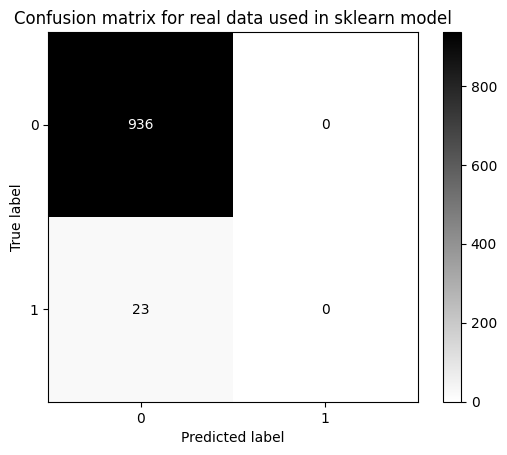

In [10]:
tree_model = RandomForestClassifier(criterion='gini', max_depth=5, min_samples_split=2, min_samples_leaf=2, n_estimators=5)
tree_model.fit(xtrain_processed,ytrain_processed.squeeze().ravel())
ypred = tree_model.predict(xtest_processed)
sensitivity, specificity, c, d = cm(ytest_processed, ypred, 'Confusion matrix for real data used in sklearn model')

Parametry dopasowane do tych dwóch modeli różnią się max_depth oraz n_estimators. Dla label=pha jest to 5 i 5, dla label=neo 10 i 100.

<h3 align="center"><font size="10">Część 3</font></h3>

<h3 align="center"><font size="10">Model własny</font></h3>

In [26]:
cosmos = pd.read_csv('dataset.csv', delimiter=',')
cosmos
cosmos = cosmos.drop(columns=['pha', 'epoch', 'equinox', 'orbit_id', 'id', 'spkid', 'full_name', 'pdes', 'epoch_cal', 'epoch_mjd', 'ad', 'per', 'per_y', 'moid', 'moid_ld', 'sigma_ad', 'sigma_per', 'sigma_ma', 'sigma_tp', 'tp_cal', 'sigma_q', 'sigma_i', 'rms'])
cosmos = cosmos.dropna(axis=1, thresh=(958524-958524*0.3))
cosmos = cosmos.dropna(axis=0, subset='neo')
cosmos.reset_index(inplace=True, drop=True)
y = cosmos[['neo']]
cosmos = cosmos.drop(columns=['neo'])
cosmos.fillna(
    {
        'class': cosmos['class'].mode().values[0],
        'H': cosmos['H'].median(),
        'ma': cosmos['ma'].mean(),
        'sigma_e': cosmos['sigma_e'].mean(),
        'sigma_a': cosmos['sigma_a'].mean(),
        'sigma_om': cosmos['sigma_om'].mean(),
        'sigma_w': cosmos['sigma_w'].mean(),
        'sigma_n': cosmos['sigma_n'].mean(),
    },
    inplace=True
)
windsorize(cosmos)

C:\Users\Jakub Kowalczewski\AppData\Local\Temp\ipykernel_9396\1054861680.py:1: DtypeWarning: Columns (3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  cosmos = pd.read_csv('dataset.csv', delimiter=',')


In [27]:
xtrain, xtest, ytrain, ytest = train_test_split(cosmos, y, stratify=y, test_size=1000, train_size=500, random_state=seed)
xtrain, ytrain = preprocess(xtrain,ytrain)
xtest, ytest = preprocess(xtest, ytest)

xtrain = np.asarray(xtrain)
ytrain = np.asarray(ytrain)
xtest = np.asarray(xtest)
ytest = np.asarray(ytest)

classifier = RandomForest(max_depth=2, n_estimators=10, min_samples_split=2)
start = time.time()
for i in range(loop):
    classifier.fit(xtrain,ytrain)
    ypred = classifier.predict(xtest)
    a, b, own_balacc_2, d = cm(ytest,ypred, 'Title', False)
own_endtime_2 = (time.time() - start)/loop

In [28]:
classifier = RandomForest(max_depth=10, n_estimators=10, min_samples_split=2)
start = time.time()
for i in range(loop):
    classifier.fit(xtrain,ytrain)
    ypred = classifier.predict(xtest)
    a, b, own_balacc_10, d = cm(ytest,ypred, 'Title', False)
own_endtime_10 = (time.time() - start)/loop

In [29]:
classifier = RandomForest(max_depth=100, n_estimators=10, min_samples_split=2)
start = time.time()
for i in range(loop):
    classifier.fit(xtrain,ytrain)
    ypred = classifier.predict(xtest)
    a, b, own_balacc_100, d = cm(ytest,ypred, 'Title', False)
own_endtime_100 = (time.time() - start)/loop

<h3 align="center"><font size="10">Model sklearn</font></h3>

In [30]:
tree_model = RandomForestClassifier(max_depth=2, n_estimators=10, min_samples_split=2)
start = time.time()
for i in range(loop):
    tree_model.fit(xtrain,ytrain.squeeze().ravel())
    ypred = tree_model.predict(xtest)
    a, b, skl_balacc_2, d = cm(ytest, ypred, 'Confusion matrix for real data used in sklearn model', False)
skl_endtime_2 = (time.time() - start)/loop

In [31]:
tree_model = RandomForestClassifier(max_depth=10, n_estimators=10, min_samples_split=2)
start = time.time()
for i in range(loop):
    tree_model.fit(xtrain,ytrain.squeeze().ravel())
    ypred = tree_model.predict(xtest)
    a, b, skl_balacc_10, d = cm(ytest, ypred, 'Confusion matrix for real data used in sklearn model', False)
skl_endtime_10 = (time.time() - start)/loop

In [32]:
tree_model = RandomForestClassifier(max_depth=100, n_estimators=10, min_samples_split=2)
start = time.time()
for i in range(loop):
    tree_model.fit(xtrain,ytrain.squeeze().ravel())
    ypred = tree_model.predict(xtest)
    a, b, skl_balacc_100, d = cm(ytest, ypred, 'Confusion matrix for real data used in sklearn model', False)
skl_endtime_100 = (time.time() - start)/loop

In [33]:
print(f'The runtime of my own model with max depth = 2 is {own_endtime_2} \n'
      f'The runtime of skl model with max depth = 2 is {skl_endtime_2} \n\n'

      f'The runtime of my own model with max depth = 10 is {own_endtime_10} \n'
      f'The runtime of skl model with max depth = 100 is {skl_endtime_10} \n\n'

      f'The runtime of my own model with max depth = 100 is {own_endtime_100} \n'
      f'The runtime of skl model with max depth = 100 is {skl_endtime_100} \n\n'

      f'Balanced accuracy of my own model with max depth = 2 is {own_balacc_2} \n'
      f'Balanced accuracy of skl model with max depth = 2 is {skl_balacc_2} \n\n'

      f'Balanced accuracy of my own model with max depth = 10 is {own_balacc_10} \n'
      f'Balanced accuracy of skl model with max depth = 10 is {skl_balacc_10} \n\n'

      f'Balanced accuracy of my own model with max depth = 100 is {own_balacc_100} \n'
      f'Balanced accuracy of skl model with max depth = 100 is {skl_balacc_100} \n\n')

The runtime of my own model with max depth = 2 is 8.590737533569335 
The runtime of skl model with max depth = 2 is 0.014109468460083008 

The runtime of my own model with max depth = 100 is 8.625268602371216 
The runtime of skl model with max depth = 100 is 0.014525890350341797 

The runtime of my own model with max depth = 10000 is 8.493909788131713 
The runtime of skl model with max depth = 10000 is 0.014403057098388673 

Balanced accuracy of my own model with max depth = 2 is 0.9375 
Balanced accuracy of skl model with max depth = 2 is 0.8953210382513661 

Balanced accuracy of my own model with max depth = 100 is 1.0 
Balanced accuracy of skl model with max depth = 100 is 0.9994877049180328 

Balanced accuracy of my own model with max depth = 10000 is 1.0 
Balanced accuracy of skl model with max depth = 10000 is 1.0 


